In [35]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.ndimage import gaussian_filter

np.random.seed(1)

# Constants
E_b = 1000.0 # Pa
E_c = 100.0 # Pa
E_s = 1.0 # Pa
h_b = 1e-2 # m
h_c = 1e-5 # m
gamma0 = 2.0 # N/m
p = 1.0


K_c = (E_c * (h_c)**3) /9
hb_hc_ratio = h_b / h_c 
Eb_Ec_ratio = E_b / E_c
Es_Ec_ratio = E_s / E_c
# non_linear_prefactor = 9 * Eb_Ec_ratio * (hb_hc_ratio)**(1/3) 
# f_el_prefactor = 3 * Es_Ec_ratio * (hb_hc_ratio)**(1/3)

non_linear_prefactor = 1.0
f_el_prefactor = 1.0
epsilon_small = 0.0

gamma_c = (3 * K_c * E_s**2 )**(1/3)
lambda_c = 2 * np.pi * (K_c / E_s)**(1/3)

print(lambda_c)
print(gamma0 / gamma_c)
print(non_linear_prefactor)
print(f_el_prefactor)

0.00014020570920327251
62144.65011907714
1.0
1.0


![title](equations.jpg)


In [36]:
def initialize_grid(total_time=5.0, Nx=128, Ny=128, Lx=16.0, Ly=16.0, dt=0.0001):

    # Parameters for the domain
    dx, dy = Lx / Nx, Ly / Ny  # Grid spacing
    steps = int(total_time / dt)

    # Create spatial grid centered at (0,0)
    x = np.linspace(-Lx / 2, Lx / 2, Nx, endpoint=False)
    y = np.linspace(-Ly / 2, Ly / 2, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y)

    # Wavenumber grids in Fourier space (centered)
    kx_unshifted = 2 * np.pi * fftfreq(Nx, d=dx)
    ky_unshifted = 2 * np.pi * fftfreq(Ny, d=dy)
    kx = fftshift(kx_unshifted)
    ky = fftshift(ky_unshifted)
    KX, KY = np.meshgrid(kx, ky)  # Shift to center k-space around (0,0)

    K_squared = KX**2 + KY**2
    K = np.sqrt(K_squared)
    K_fourth = K_squared**2

    # Handling division by zero at k=0
    K[K == 0] = 1e-20
    K_squared[K_squared == 0] = 1e-20
    center_idx = Nx // 2

    return Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx

def fft_transform(field, normalize=True):
    transformed = fftshift(fft2(field))
    # if normalize:
    #     transformed /= field.size  # Normalize by grid size
    return transformed

def ifft_transform(field_tilde, normalize=True, real_output=True):
    field = ifft2(ifftshift(field_tilde))
    # if normalize:
    #     field *= field_tilde.size  # Normalize by grid size
    return np.real(field) if real_output else field


def plot_3d(x, y, z, title):
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('w')
    ax.view_init(elev=45, azim=-135)
    ax.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, antialiased=True)

    mappable = plt.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(z)
    plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
    plt.show()

def plot_2d(x, y, z, title):
    
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(x, y, z, cmap='viridis')
    plt.colorbar(label='w')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
    plt.show()

def animate(w_array, w_tilde_array, X, Y, KX, KY, dt, w, w_tilde, title):
    # Initialize the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Setup for w (real space)
    real_space_plot = ax2.pcolormesh(X, Y, w_array[0], cmap='viridis', shading='auto')
    ax2.set_title(f'Real Space {w}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal')
    real_colorbar = plt.colorbar(real_space_plot, ax=ax2)

    # Setup for w_tilde (Fourier space)
    fourier_space_plot = ax1.pcolormesh(KX, KY, np.abs(w_tilde_array[0]), cmap='viridis', shading='auto')
    ax1.set_title(f'Fourier Space {w_tilde}')
    ax1.set_xlabel('kx')
    ax1.set_ylabel('ky')
    ax1.set_aspect('equal')
    fourier_colorbar = plt.colorbar(fourier_space_plot, ax=ax1)

    # Update function for animation
    def update(frame):
        real_space_plot.set_array(w_array[frame].ravel())
        real_space_plot.set_clim(vmin=w_array[frame].min(), vmax=w_array[frame].max())  # Dynamically rescale
        real_colorbar.update_normal(real_space_plot)

        # Update Fourier space data
        fourier_space_plot.set_array(np.abs(w_tilde_array[frame]).ravel())
        fourier_space_plot.set_clim(vmin=np.abs(w_tilde_array[frame]).min(), vmax=np.abs(w_tilde_array[frame]).max())  # Dynamically rescale
        fourier_colorbar.update_normal(fourier_space_plot)

        # Update titles with the current time
        ax2.set_title(f'Real Space (w), Time: {frame * dt:.2f}')
        ax1.set_title(f'Fourier Space (w_tilde), Time: {frame * dt:.2f}')
        return fourier_space_plot, real_space_plot

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w_array), blit=False)
    ani.event_source.interval = 2000  # Set the interval between frames in milliseconds
    # Save the animation as a video file or show it
    ani.save(title, fps=10, extra_args=['-vcodec', 'libx264'])
    plt.show()

def generate_smooth_random_2d_array(size=(100, 100), sigma=1.0):
    # Generate random noise
    noise = np.random.normal(size=size)
    
    # Apply Gaussian filter to smooth the noise
    smooth_array = gaussian_filter(noise, sigma=sigma)
    
    return smooth_array

# plt.imshow(smooth_array, cmap='viridis')
# plt.colorbar()
# plt.title('Smooth Random 2D Array (Gaussian Filter)')
# plt.show()

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid()

# w = np.exp((-X*X - Y*Y)/4086) * 0.1

# w = np.sin(2 * np.pi * X / 32)

# w_tilde = fft_transform(w)

# plot_2d(X, Y, w, 'Initial condition')
# plot_2d(KX, KY, np.abs(w_tilde), 'Initial condition in Fourier space')

# plot_3d(X, Y, w, 'Initial condition')
# plot_3d(KX, KY, np.abs(w_tilde), 'Initial condition in Fourier space')

## Linear parts

In [37]:
def linear_update_scheme(field_tilde, lamda_k, delta_t):
    return field_tilde * np.exp(lamda_k * delta_t)

def compute_k_matrix(KX, KY, K, K_squared, f_el_prefactor):

    KX_squared = KX**2
    KY_squared = KY**2

    M11 = f_el_prefactor * (2 * K_squared - KY_squared)/ K
    M12 = f_el_prefactor * (KX * KY) / K
    M22 = f_el_prefactor * (2 * K_squared - KX_squared) / K

    return np.stack([M11, M12, M12, M22], axis=0)

def compute_exp_k_matrix_dt(KX, KY, K, K_squared, delta_t, f_el_prefactor):

    exp_k_dt = np.exp(K * delta_t * f_el_prefactor)
    exp_2k_dt = np.exp(2 * K * delta_t * f_el_prefactor)
    KX_squared = KX**2
    KY_squared = KY**2

    M11 = (KX_squared * exp_2k_dt + KY_squared * exp_k_dt) / K_squared
    M12 = (KX * KY * (exp_2k_dt - exp_k_dt)) / K_squared
    M22 = (KY_squared * exp_2k_dt + KX_squared * exp_k_dt) / K_squared

    return np.stack([M11, M12, M12, M22], axis=0)

In [38]:
def linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0):

    lambda_k = -K_fourth + gamma0 * K_squared - 2*K
    w_tilde_new = linear_update_scheme(w_tilde, lambda_k, dt)

    return w_tilde_new

def linear_first_order_scheme_for_u1_and_u2(u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KX, KY):

    k_matrix = compute_exp_k_matrix_dt(KX, KY, K, K_squared, dt, f_el_prefactor)

    M11 = k_matrix[0]
    M12 = k_matrix[1]
    M22 = k_matrix[3]

    u1_tilde_new = M11 * u1_tilde + M12 * u2_tilde
    u2_tilde_new = M12 * u1_tilde + M22 * u2_tilde

    return np.stack([u1_tilde_new, u2_tilde_new], axis=0)


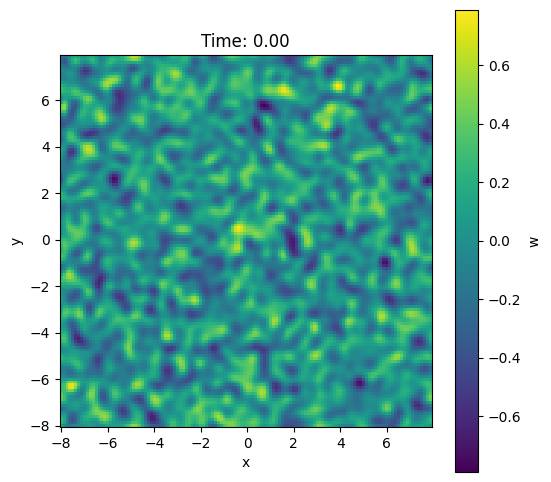

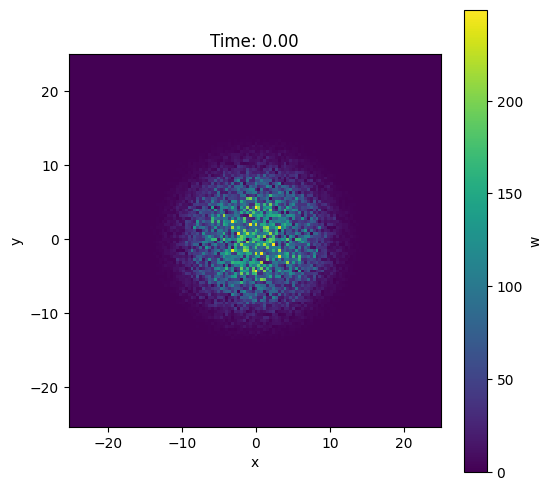

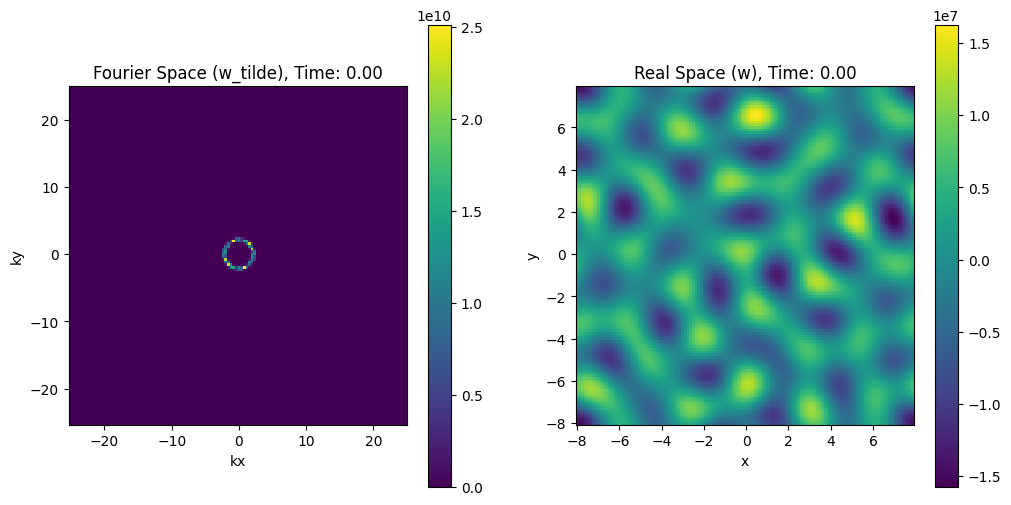

In [39]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(total_time=1, Lx=16, Ly=16)

gamma0 = 10.0
non_linear_prefactor = 1.0
f_el_prefactor = 1.0

# w = generate_smooth_random_2d_array(size=(Nx, Ny))  # Initial condition
# w = np.ones((Nx, Ny))9
# w = np.exp((-X*X - Y*Y)/256)
# w = np.exp((-X*X - Y*Y))
#w = np.cos(2 * np.pi * X / 32) + np.cos(2 * np.pi * Y / 32)
# u1 = np.zeros((Nx, Ny))  # Initial displacement in x direction
# u2 = np.zeros((Nx, Ny))  # Initial displacement in y direction

w = generate_smooth_random_2d_array(size=(int(Nx), int(Ny)), sigma=1.0)
# w = np.ones((int(Nx/2), int(Ny/2))) * 0.1
u1 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)
u2 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)

w = np.tile(w, (Nx // w.shape[0], Ny // w.shape[1]))
u1 = np.tile(u1, (Nx // u1.shape[0], Ny // u1.shape[1]))
u2 = np.tile(u2, (Nx // u2.shape[0], Ny // u2.shape[1]))

w_values = []  # List to store the value of w at center (0,0) over time
# Fourier transform of w
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

w_array = []
w_tilde_array = []


for step in range(steps):
    
    w_tilde_new = linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0)
    u1_and_u2_new = linear_first_order_scheme_for_u1_and_u2(u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KX, KY)
    u1_tilde_new = u1_and_u2_new[0]
    u2_tilde_new = u1_and_u2_new[1]


    # Inverse Fourier transform to get updated w in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)

    # Update Fourier components for the next step
    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new

    # Store the value of w at (0,0) for analysis
    if step % 1000 == 0:
        # x_idx = 21
        # y_idx = 0
        # storing_idx = (center_idx + x_idx, center_idx + y_idx)
        w_array.append(w)
        w_tilde_array.append(w_tilde)
        # epsilon = 1e-10  # A small value to avoid log(0)
        # # w_values.append(math.log(np.abs(w_tilde_new[storing_idx])))

    if step % 10000 == 0:
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
 
# After the simulation loop is complete
animate(w_array, w_tilde_array, X, Y, KX, KY, dt, 'w', 'w_tilde', 'second_order/linear_wave_equation.mp4')

## Non linear

In [40]:
def fourier_derivative_x(field_tilde, KX): ## returns in fourier space
    return 1j * KX * field_tilde

def fourier_derivative_y(field_tilde, KY): ## returns in fourier space
    return 1j * KY * field_tilde

def derivative_x(field_tilde, KX): ## returns in real space

    dfield_dx_tilde = fourier_derivative_x(field_tilde, KX)  # Differentiate in Fourier space
    dfield_dx = ifft_transform(dfield_dx_tilde)  # Transform back to real space
    
    return dfield_dx

def derivative_y(field_tilde, KY): ## returns in real space

    dfield_dy_tilde = fourier_derivative_y(field_tilde, KY)  # Differentiate in Fourier space
    dfield_dy = ifft_transform(dfield_dy_tilde)  # Transform back to real space
    
    return dfield_dy

def laplacian(field_tilde, K_squared): ## returns in real space

    laplacian_tilde = -K_squared * field_tilde  # Laplacian in Fourier space
    laplacian = ifft_transform(laplacian_tilde)  # Transform back to real space

    return laplacian


In [41]:
def compute_strain_matrix(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small): ## returns in real space

    du1_dx = derivative_x(u1_tilde, KX)
    du1_dy = derivative_y(u1_tilde, KY)
    du2_dx = derivative_x(u2_tilde, KX)
    du2_dy = derivative_y(u2_tilde, KY)
    dw_dx  = derivative_x(w_tilde, KX)
    dw_dy  = derivative_y(w_tilde, KY)

    epsilon_xx = du1_dx + 0.5  * (dw_dx * dw_dx) * epsilon_small**2
    epsilon_yy = du2_dy + 0.5 * (dw_dy * dw_dy) * epsilon_small**2
    epsilon_xy = 0.5 * (du1_dy + du2_dx + dw_dx * dw_dy * epsilon_small**2)

    return np.stack([epsilon_xx, epsilon_yy, epsilon_xy], axis=0)

def u1_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor): ## returns in real space

    strain_matrix = compute_strain_matrix(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small)
    epsilon_xx = strain_matrix[0]
    epsilon_yy = strain_matrix[1]
    epsilon_xy = strain_matrix[2]

    epsilon_xx_tilde = fft_transform(epsilon_xx)
    epsilon_yy_tilde = fft_transform(epsilon_yy)
    epsilon_xy_tilde = fft_transform(epsilon_xy)

    dexx_dx = derivative_x(epsilon_xx_tilde, KX)
    dexy_dy = derivative_y(epsilon_xy_tilde, KY)

    total_term = non_linear_prefactor * (dexx_dx + dexy_dy)

    return total_term

def u2_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor): ## returns in real space

    strain_matrix = compute_strain_matrix(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small)
    epsilon_xx = strain_matrix[0]
    epsilon_yy = strain_matrix[1]
    epsilon_xy = strain_matrix[2]

    epsilon_xx_tilde = fft_transform(epsilon_xx)
    epsilon_yy_tilde = fft_transform(epsilon_yy)
    epsilon_xy_tilde = fft_transform(epsilon_xy)

    deyy_dy = derivative_y(epsilon_yy_tilde, KY)
    dexy_dx = derivative_x(epsilon_xy_tilde, KX)

    total_term = non_linear_prefactor * (deyy_dy + dexy_dx)

    return total_term


def w_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor, p): ## returns in real space

    strain_matrix = compute_strain_matrix(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small)
    epsilon_xx = strain_matrix[0]
    epsilon_yy = strain_matrix[1]
    epsilon_xy = strain_matrix[2]

    dw_dx = derivative_x(w_tilde, KX)
    dw_dy = derivative_y(w_tilde, KY)

    first_term = epsilon_xx * dw_dx + epsilon_xy * dw_dy
    second_term = epsilon_xy * dw_dx + epsilon_yy * dw_dy

    first_term_tilde = fft_transform(first_term)
    second_term_tilde = fft_transform(second_term)

    d_first_term_dx = derivative_x(first_term_tilde, KX)
    d_second_term_dy = derivative_y(second_term_tilde, KY)

    w = ifft_transform(w_tilde)
    lap_w = laplacian(w_tilde, K_squared)

    w_term = p * w * lap_w

    total_term = non_linear_prefactor * (d_first_term_dx + d_second_term_dy) + w_term

    return total_term


In [42]:
def non_linear_update_scheme(non_linear_field_tilde, lambda_k, delta_t): ## returns in fourier space 
    # Define a threshold to consider lambda_k effectively zero.
    threshold = 1e-20
    # Use np.where to choose elementwise:
    # If |lambda_k| < threshold, simply multiply by delta_t.
    # Otherwise, use the exponential update.
    update = np.where(
        np.abs(lambda_k) < threshold,
        delta_t * non_linear_field_tilde,
        (np.exp(lambda_k * delta_t) - 1) * non_linear_field_tilde / lambda_k
    )
    return update

def non_linear_update_scheme_current(non_linear_field_tilde, lambda_k, delta_t): ## returns in fourier space

    update = non_linear_field_tilde * np.exp(lambda_k * delta_t) * delta_t * 1.5
    return update

def non_linear_update_scheme_previous(non_linear_field_tilde, lambda_k, delta_t): ## returns in fourier space

    update = -non_linear_field_tilde * np.exp(2 * lambda_k * delta_t) * delta_t * 0.5
    return update


In [43]:
def non_linear_first_order_scheme_for_w(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, K_fourth, f_el_prefactor, 
                                        non_linear_prefactor, epsilon_small, gamma0, p): ## returns in fourier space

    total_term = w_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor, p)
    total_term_tilde = fft_transform(total_term)

    lambda_k = -K_fourth + gamma0 * K_squared - 2*K

    w_tilde_new = non_linear_update_scheme(total_term_tilde, lambda_k, dt)
    
    return w_tilde_new

def non_linear_first_order_scheme_for_u1_and_u2(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, f_el_prefactor, 
                                        non_linear_prefactor, epsilon_small): ## returns in fourier space

    non_linear_term_u1 = u1_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor)
    non_linear_term_u1_tilde = fft_transform(non_linear_term_u1)

    non_linear_term_u2 = u2_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor)
    non_linear_term_u2_tilde = fft_transform(non_linear_term_u2)

    k_matrix = compute_exp_k_matrix_dt(KX, KY, K, K_squared, dt, f_el_prefactor)
    K11 = k_matrix[0]
    K12 = k_matrix[1]
    K22 = k_matrix[2]
    
    u1_tilde_new = u1_tilde + (K11 * u1_tilde + K12 * u2_tilde + non_linear_term_u1_tilde) * dt
    u2_tilde_new = u2_tilde + (K12 * u1_tilde + K22 * u2_tilde + non_linear_term_u2_tilde) * dt

    return np.stack([u1_tilde_new, u2_tilde_new], axis=0)

In [44]:
def non_linear_second_order_scheme_for_w(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, K_fourth, f_el_prefactor, 
                                        non_linear_prefactor, epsilon_small, gamma0, p, non_linear_w_tilde_previous):

    total_term = w_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor, p)
    total_term_tilde = fft_transform(total_term)

    lambda_k = -K_fourth + gamma0 * K_squared - 2*K

    w_tilde_current = non_linear_update_scheme_current(total_term_tilde, lambda_k, dt)
    w_tilde_previous = non_linear_update_scheme_previous(non_linear_w_tilde_previous, lambda_k, dt)

    w_tilde_new = w_tilde_current + w_tilde_previous
    
    return w_tilde_new

def non_linear_second_order_scheme_for_u1_and_u2(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, f_el_prefactor, 
                                        non_linear_prefactor, epsilon_small, u1_non_linear_tilde_previous, u2_non_linear_tilde_previous):

    non_linear_term_u1 = u1_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor)
    non_linear_term_u1_tilde = fft_transform(non_linear_term_u1)

    non_linear_term_u2 = u2_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor)
    non_linear_term_u2_tilde = fft_transform(non_linear_term_u2)

    exp_k_matrix = compute_exp_k_matrix_dt(KX, KY, K, K_squared, dt, f_el_prefactor)
    M11 = exp_k_matrix[0]
    M12 = exp_k_matrix[1]
    M22 = exp_k_matrix[2]

    new_u1_tilde_current = 1.5 * (M11 * non_linear_term_u1_tilde + M12 * non_linear_term_u2_tilde) * dt
    new_u2_tilde_current = 1.5 * (M12 * non_linear_term_u1_tilde + M22 * non_linear_term_u2_tilde) * dt

    new_u1_tilde_previous = -0.5 * (M11 * u1_non_linear_tilde_previous + M12 * u2_non_linear_tilde_previous) * dt
    new_u2_tilde_previous = -0.5 * (M12 * u1_non_linear_tilde_previous + M22 * u2_non_linear_tilde_previous) * dt

    u1_tilde_new = new_u1_tilde_current + new_u1_tilde_previous
    u2_tilde_new = new_u2_tilde_current + new_u2_tilde_previous

    return np.stack([u1_tilde_new, u2_tilde_new], axis=0)

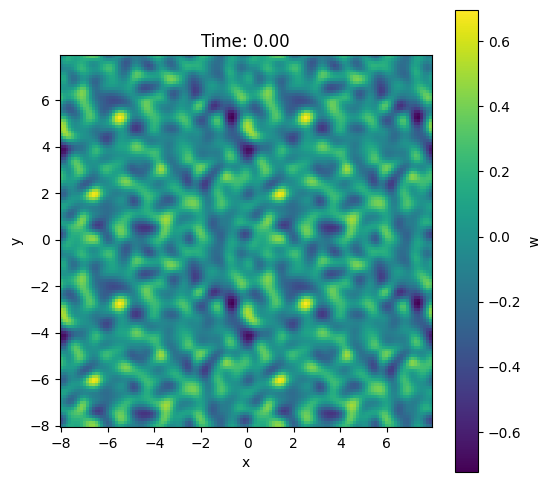

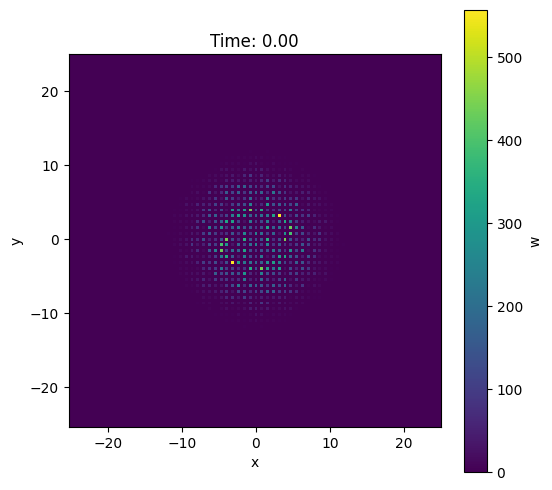

C:\Users\Hp\AppData\Local\Temp\ipykernel_15280\3088537959.py:10: RuntimeWarning: overflow encountered in multiply
  epsilon_xx = du1_dx + 0.5  * (dw_dx * dw_dx) * epsilon_small**2
C:\Users\Hp\AppData\Local\Temp\ipykernel_15280\3088537959.py:11: RuntimeWarning: overflow encountered in multiply
  epsilon_yy = du2_dy + 0.5 * (dw_dy * dw_dy) * epsilon_small**2
C:\Users\Hp\AppData\Local\Temp\ipykernel_15280\3088537959.py:12: RuntimeWarning: overflow encountered in multiply
  epsilon_xy = 0.5 * (du1_dy + du2_dx + dw_dx * dw_dy * epsilon_small**2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_15280\472425251.py:2: RuntimeWarning: invalid value encountered in multiply
  return 1j * KX * field_tilde
C:\Users\Hp\AppData\Local\Temp\ipykernel_15280\472425251.py:5: RuntimeWarning: invalid value encountered in multiply
  return 1j * KY * field_tilde


In [ ]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(total_time=1, Lx=16, Ly=16)

gamma0 = 10.0
non_linear_prefactor = 1.0
f_el_prefactor = 1.0
epsilon_small = 1.0
p = 0.0

w = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)
u1 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)
u2 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)

w = np.tile(w, (Nx // w.shape[0], Ny // w.shape[1]))
u1 = np.tile(u1, (Nx // u1.shape[0], Ny // u1.shape[1]))
u2 = np.tile(u2, (Nx // u2.shape[0], Ny // u2.shape[1]))

# u1 = generate_smooth_random_2d_array(size=(int(Nx), int(Ny)), sigma=1.0)
# u2 = generate_smooth_random_2d_array(size=(int(Nx), int(Ny)), sigma=1.0)
# Fourier transform of w

w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

w_array = []
w_tilde_array = []

u1_array = []
u1_tilde_array = []

u2_array = []
u2_tilde_array = []

w_tilde_new_linear = linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0)
linear_u1_and_u2 = linear_first_order_scheme_for_u1_and_u2(u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KX, KY)
u1_tilde_new_linear = linear_u1_and_u2[0]
u2_tilde_new_linear = linear_u1_and_u2[1]

w_tilde_new_non_linear = non_linear_first_order_scheme_for_w(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, K_fourth, f_el_prefactor,
                                    non_linear_prefactor, epsilon_small, gamma0, p)
non_linear_u1_and_u2 = non_linear_first_order_scheme_for_u1_and_u2(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, f_el_prefactor,
                                    non_linear_prefactor, epsilon_small)
u1_tilde_new_non_linear = non_linear_u1_and_u2[0]
u2_tilde_new_non_linear = non_linear_u1_and_u2[1]

w_tilde = w_tilde_new_linear + w_tilde_new_non_linear
u1_tilde = u1_tilde_new_linear + u1_tilde_new_non_linear
u2_tilde = u2_tilde_new_linear + u2_tilde_new_non_linear

w_non_linear_previous = w_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor, p)
u1_non_linear_previous = u1_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor)
u2_non_linear_previous = u2_non_linear(w_tilde, u1_tilde, u2_tilde, KX, KY, epsilon_small, non_linear_prefactor)

w_non_linear_previous_tilde = fft_transform(w_non_linear_previous)
u1_non_linear_previous_tilde = fft_transform(u1_non_linear_previous)
u2_non_linear_previous_tilde = fft_transform(u2_non_linear_previous)

for step in range(steps):

    w_tilde_new_linear = linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0)
    linear_u1_and_u2 = linear_first_order_scheme_for_u1_and_u2(u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KX, KY)
    u1_tilde_new_linear = linear_u1_and_u2[0]
    u2_tilde_new_linear = linear_u1_and_u2[1]

    w_tilde_new_non_linear = non_linear_second_order_scheme_for_w(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, K_fourth, f_el_prefactor,
                                    non_linear_prefactor, epsilon_small, gamma0, p, w_non_linear_previous_tilde)
    non_linear_u1_and_u2 = non_linear_second_order_scheme_for_u1_and_u2(w_tilde, u1_tilde, u2_tilde, dt, KX, KY, K, K_squared, f_el_prefactor,
                                    non_linear_prefactor, epsilon_small, u1_non_linear_previous_tilde, u2_non_linear_previous_tilde)
    u1_tilde_new_non_linear = non_linear_u1_and_u2[0]
    u2_tilde_new_non_linear = non_linear_u1_and_u2[1]

    w_tilde_new = w_tilde_new_linear + w_tilde_new_non_linear
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_non_linear
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_non_linear

    w_non_linear_previous = w_non_linear(w_tilde_new, u1_tilde_new, u2_tilde_new, KX, KY, epsilon_small, non_linear_prefactor, p)
    u1_non_linear_previous = u1_non_linear(w_tilde_new, u1_tilde_new, u2_tilde_new, KX, KY, epsilon_small, non_linear_prefactor)
    u2_non_linear_previous = u2_non_linear(w_tilde_new, u1_tilde_new, u2_tilde_new, KX, KY, epsilon_small, non_linear_prefactor)

    w_non_linear_previous_tilde = fft_transform(w_non_linear_previous)
    u1_non_linear_previous_tilde = fft_transform(u1_non_linear_previous)
    u2_non_linear_previous_tilde = fft_transform(u2_non_linear_previous)

    # Update Fourier components for the next step
    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new

    # Inverse Fourier transform to get updated w in real space
    w = ifft_transform(w_tilde)
    u1 = ifft_transform(u1_tilde)
    u2 = ifft_transform(u2_tilde)

    # Store the value of w at (0,0) for analysis
    if step % 100 == 0:

        w_array.append(w)
        w_tilde_array.append(w_tilde)

        u1_array.append(u1)
        u1_tilde_array.append(u1_tilde)

        u2_array.append(u2)
        u2_tilde_array.append(u2_tilde)


    if step % 10000 == 0:
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')

# After the simulation loop is complete
animate(w_array, w_tilde_array, X, Y, KX, KY, dt, 'w', 'w_tilde', 'second_order/w_tiled_gamma0_10_p_1_epsilon_1.mp4')
animate(u1_array, u1_tilde_array, X, Y, KX, KY, dt, 'u1', 'u1_tilde', 'second_order/u1_tiled_gamma0_10_p_1_epsilon_1.mp4')
animate(u2_array, u2_tilde_array, X, Y, KX, KY, dt, 'u2', 'u2_tilde', 'second_order/u2_tiled_gamma0_10_p_1_epsilon_1.mp4')